In [76]:
import pandas as pd

In [77]:
df = pd.read_csv("SemArt/semart_train.csv", sep="	", encoding="unicode_escape")
df.columns = df.columns.str.lower()

In [78]:
len(df["timeframe"].unique())

22

In [79]:
df.columns

Index(['image_file', 'description', 'author', 'title', 'technique', 'date',
       'type', 'school', 'timeframe'],
      dtype='object')

In [80]:
df.groupby("timeframe").size()

timeframe
0751-0800       2
0801-0850       5
0851-0900       3
0951-1000       4
1001-1050       1
1051-1100      26
1101-1150      14
1151-1200      21
1201-1250      29
1251-1300     116
1301-1350     670
1351-1400     347
1401-1450     938
1451-1500    2059
1501-1550    2576
1551-1600    1582
1601-1650    3404
1651-1700    2088
1701-1750    1444
1751-1800    1114
1801-1850    1056
1851-1900    1745
dtype: int64

In [81]:
df.groupby("school").size().sort_values()

school
Finnish             5
Portuguese          5
Polish             16
Norwegian          18
Irish              21
Other              22
Swedish            23
Bohemian           29
Catalan            35
Greek              37
Belgian            45
Scottish           46
Russian            68
Swiss              89
Danish             94
American          113
Hungarian         178
Austrian          216
Netherlandish     217
English           411
Spanish           852
German           1173
Flemish          2016
French           2556
Dutch            2948
Italian          8011
dtype: int64

In [82]:
df.groupby("type").size().sort_values()

type
study             57
interior         452
other            509
historical       545
still-life       926
genre           1630
mythological    1862
landscape       2490
portrait        3292
religious       7481
dtype: int64

In [83]:
technique_df = df.groupby("technique").size().to_frame()

# Development
## Setup
Setting up configurations such as label encoding and different types of data sets

In [ ]:
from enum import Enum


class DataSetEnum(Enum):
    TRAIN = "train"
    TEST = "test"
    VALIDATION = "val"


class OutputEnum(Enum):
    TIMEFRAME = "timeframe"
    SCHOOL = "school"
    TYPE = "type"


timeframe_encoder = {
    "1401-1450": 0,
    "1451-1500": 1,
    "1501-1550": 2,
    "1551-1600": 3,
    "1601-1650": 4,
    "1651-1700": 5,
    "1701-1750": 6,
    "1751-1800": 7,
    "1801-1850": 8,
    "1851-1900": 9,
}

school_encoder = {
    "Finnish": 0,
    "Portuguese": 0,
    "Polish": 0,
    "Norwegian": 0,
    "Irish": 0,
    "Other": 0,
    "Swedish": 0,
    "Bohemian": 0,
    "Catalan": 0,
    "Greek": 0,
    "Belgian": 0,
    "Scottish": 0,
    "Russian": 0,
    "Swiss": 0,
    "Danish": 0,
    "American": 0,
    "Hungarian": 0,
    "Austrian": 0,
    "Netherlandish": 0,
    "English": 0,
    "Spanish": 1,
    "German": 2,
    "Flemish": 3,
    "French": 4,
    "Dutch": 5,
    "Italian": 6,
}

type_encoder = {
    "study": 0,
    "interior": 0,
    "other": 0,
    "historical": 0,
    "still-life": 0,
    "genre": 1,
    "mythological": 2,
    "landscape": 3,
    "portrait": 4,
    "religious": 5,
}

## CNN
Building the model, we are using a pre-trained CNN model called resnet.

In [84]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class CNN(nn.Module):
    def __init__(self, output_dim: int):
        super(CNN, self).__init__()
        self.output_dim = output_dim
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.resnet.requires_grad_(False)
        self.resnet.fc = nn.Linear(2048, output_dim)
        self.resnet.fc.requires_grad_(True)

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        x = self.resnet(x)
        return x


Using device: cuda


## Dataloader

We make use of a data loader that dynamically loads the dataset so that we avoid loading all of the images (training set has over 19k images) into memory. We also define some transformations, that are following how resnet was trained. For the training set we are doing some data augmentation to avoid overfitting while training.

In [85]:
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image


class ImageDataset(Dataset):
    def __init__(self, data_set: DataSetEnum, output: OutputEnum):
        self.data_set = data_set
        self.output = output
        self.data = pd.read_csv(
            f"SemArt/semart_{data_set.value}.csv", sep="	", encoding="unicode_escape"
        )
        self.data.columns = self.data.columns.str.lower()
        self._base_path = Path() / "SemArt" / "Images"
        self.transform = transforms.Compose(
            [
                # Get the values from here: https://pytorch.org/vision/0.18/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
                transforms.Resize(232),
                # Data augmentation, randomly crop the image and flip it horizontally
                # only for the training set
                transforms.RandomCrop(224)
                if data_set == DataSetEnum.TRAIN
                else transforms.CenterCrop(224),
                transforms.RandomHorizontalFlip()
                if data_set == DataSetEnum.TRAIN
                else transforms.Lambda(lambda x: x),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.encoder = (
            timeframe_encoder
            if output == OutputEnum.TIMEFRAME
            else school_encoder
            if output == OutputEnum.SCHOOL
            else type_encoder
            if output == OutputEnum.TYPE
            else None
        )
        assert self.encoder is not None, "Invalid output type"
        self.data = self.data[self.data[self.output.value].isin(self.encoder.keys())]
        self.data = self.data.reset_index(drop=True)
        self._output_dim = len(set(self.encoder.values()))

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        # Set label
        label = -1
        label = self.encoder[self.data[self.output.value][idx]]  # type: ignore

        assert label >= 0, "No label found, invalid output type"

        # load image
        raw_image = Image.open(
            str((self._base_path / str(self.data["image_file"][idx])).resolve())
        ).convert("RGB")
        image: torch.Tensor = self.transform(raw_image)  # type: ignore
        image = image.to(device)
        return image, label


### Oversampling
Because the dataset is imbalanced in the classes that we are training on we have to use oversampling, here we create a `WeightedRandomSampler` that create probabilities based on how common a class is, this is only used for the training set.

In [86]:
def get_weights_for_balanced_sampler(dataset: ImageDataset) -> np.ndarray:
    output_dim = dataset._output_dim
    class_sizes = np.zeros(output_dim)
    encoder = dataset.encoder
    assert encoder is not None
    for key, val in encoder.items():
        class_sizes[val] += len(dataset.data[dataset.data[dataset.output.value] == key])

    weights = np.zeros(len(dataset))
    for idx, row in enumerate(dataset.data.iterrows()):
        weights[idx] = len(dataset) / class_sizes[encoder[row[1][dataset.output.value]]]

    return weights


train_dataset = ImageDataset(DataSetEnum.TRAIN, OutputEnum.TYPE)
weights = get_weights_for_balanced_sampler(train_dataset)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=WeightedRandomSampler(weights, len(weights)),
)
test_dataset = ImageDataset(DataSetEnum.TEST, OutputEnum.TYPE)
test_dataloader = DataLoader(test_dataset, batch_size=32)

## Training

In [87]:
from torch.utils.tensorboard.writer import SummaryWriter

# Use tensorboard to visualize the training process
writer = SummaryWriter()

In [88]:
# Create the model, loss function and optimizer
model = CNN(train_dataset._output_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
params = model.parameters()
optimizer = torch.optim.AdamW(params, lr=1e-2)
print(model)

CNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [89]:
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Helper function to plot the class prediction
def plot_class_prediction(net, images, labels):
    preds = net(images)
    probs = F.softmax(preds, dim=1)
    fig = plt.figure(figsize=(6, 6))
    labels = labels.cpu().numpy()
    images = images.cpu()
    probs = probs.cpu().detach().numpy()
    for idx in np.arange(6):
        ax = fig.add_subplot(2, 3, idx + 1, xticks=[], yticks=[])
        image = images[idx].numpy().transpose(1, 2, 0)
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image)
        ax.set_title(
            f"{labels[idx]} -> {probs[idx].argmax()}({probs[idx].max():.2f})",
            color=("green" if probs[idx].argmax() == labels[idx] else "red"),
        )
    return fig

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import tqdm

# TRAIN
def train(model, train_dataloader, criterion, optimizer, writer, epoch):
    size = len(train_dataloader)
    model.train()
    try:
        for batch, (images, labels) in tqdm(
            enumerate(train_dataloader),
            total=size,
            leave=False,
            desc=f"Training {epoch + 1}",
            position=1,
        ):
            pred = model(images)
            labels = labels.to(device)
            loss = criterion(pred, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if batch % 10 == 0:
                # accuracy
                accuracy = (pred.argmax(1) == labels).sum().item() / len(labels)
                writer.add_scalars(
                    "Train/Loss", {"train": loss.item()}, batch + size * epoch
                )
                writer.add_scalars(
                    "Train/Accuracy", {"train": accuracy}, batch + size * epoch
                )
                print(
                    f"{batch}/{size} - train loss: {loss.item():.4f} - train accuracy: {accuracy:.4f}"
                )

    except KeyboardInterrupt:
        print("Training interrupted")
        torch.save(model.state_dict(), "model.pth")
        raise KeyboardInterrupt


# TEST
def test(model, test_dataloader, criterion, writer, epoch):
    size = len(test_dataloader)
    model.eval()
    with torch.no_grad():
        confusion_matrix = np.zeros(
            (test_dataloader.dataset._output_dim, test_dataloader.dataset._output_dim)
        )
        random_index = np.random.randint(0, size)
        for batch, (images, labels) in tqdm(
            enumerate(test_dataloader),
            total=size,
            leave=False,
            desc=f"Testing {epoch + 1}",
            position=1,
        ):
            pred = model(images)
            labels = labels.to(device)
            loss = criterion(pred, labels)
            accuracy = (pred.argmax(1) == labels).sum().item() / len(labels)
            writer.add_scalars("Test/Loss", {"test": loss.item()}, batch + size * epoch)
            writer.add_scalars(
                "Test/Accuracy", {"test": accuracy}, batch + size * epoch
            )
            print(
                f"{batch}/{size} - test loss: {loss.item():.4f} - test accuracy: {accuracy:.4f}"
            )

            # confusion matrix
            for idx, (p, l) in enumerate(zip(pred.argmax(1), labels)):
                confusion_matrix[l.item(), p.item()] += 1

            if batch == random_index:
                writer.add_figure(
                    "Class Prediction",
                    plot_class_prediction(model, images, labels),
                    epoch,
                    close=True,
                )

        # plot confusion matrix
        fig = plt.figure()
        plt.imshow(confusion_matrix, cmap="viridis")
        plt.colorbar()
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        writer.add_figure("Confusion Matrix", fig, epoch, close=True)


epochs = 10
for epoch in tqdm(range(epochs), desc="Epochs", leave=True, total=epochs, position=0):
    clear_output(wait=True)
    train(model, train_dataloader, criterion, optimizer, writer, epoch)
    clear_output(wait=True)
    test(model, test_dataloader, criterion, writer, epoch)

# Save the model
torch.save(model.state_dict(), "model_trained.pth")


Training 5:   0%|          | 0/602 [00:00<?, ?it/s]

0/602 - train loss: 0.4772 - train accuracy: 0.8125
Training interrupted


KeyboardInterrupt: 

## Validation
We calculate some metrics on the validation set and show some examples

  0%|          | 0/34 [00:00<?, ?it/s]

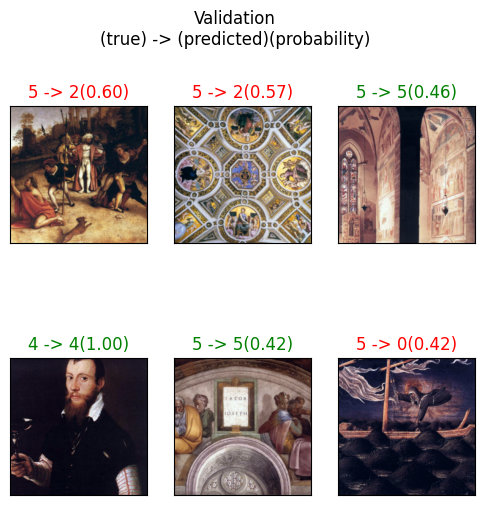

Test loss: 1.437
Test accuracy: 0.608
Precision for class 0: 0.561
Precision for class 1: 0.266
Precision for class 2: 0.734
Precision for class 3: 0.906
Precision for class 4: 0.872
Precision for class 5: 0.474


In [111]:
# Validation
model.eval()
test_dataset = ImageDataset(DataSetEnum.VALIDATION, OutputEnum.TYPE)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

running_loss = 0.0
running_accuracy = 0.0
running_precisions_numerator = {i: 0.0 for i in range(test_dataset._output_dim)}
running_precision_denominator = {i: 0.0 for i in range(test_dataset._output_dim)}
with torch.no_grad():
    random_index = np.random.randint(0, len(test_dataloader))
    for batch_n, (images, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader), leave=False)):
        pred = model(images)
        labels = labels.to(device)
        loss = criterion(pred, labels)
        running_loss += loss.item()
        running_accuracy += (pred.argmax(1) == labels).sum().item() / len(labels)
        if batch_n == random_index:
            fig = plot_class_prediction(model, images, labels)
            plt.suptitle("Validation\n(true) -> (predicted)(probability)")
            plt.show()
        for idx, (p, l) in enumerate(zip(pred.argmax(1), labels)):
            running_precisions_numerator[l.item()] += p.item() == l.item()
            running_precision_denominator[l.item()] += 1

        
print(f"Test loss: {running_loss / len(test_dataloader):.3f}")
print(f"Test accuracy: {running_accuracy / len(test_dataloader):.3f}")
for i in range(test_dataset._output_dim):
    print(f"Precision for class {i}: {running_precisions_numerator[i] / running_precision_denominator[i]:.3f}")